Name: Shobhit Verma\
Class: BE COMPS\
Batch: D\
Roll No: 33 \
UID: 2018130062
# <center> Experiment - 1B </center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# **LOADING THE DATAFRAME**

In [2]:
df = pd.read_csv ('../input/horse-colic/horse.csv')

In [3]:
dfTrain,dfTest = train_test_split(df, test_size=0.3, random_state=0)

In [4]:
dfTrain.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,2.090000e+02,168.000000,193.000000,172.000000,38.000000,188.000000,188.000000,65.000000,209.00000,209.000000,209.0
mean,1.122420e+06,38.172024,72.777202,30.656977,5.126316,46.662234,21.422872,3.255385,3476.46890,14.885167,0.0
std,1.574079e+06,0.746162,29.019517,17.834647,1.800253,10.749158,25.778575,2.012696,5374.19771,215.192370,0.0
min,5.213990e+05,35.400000,30.000000,8.000000,1.500000,23.000000,3.300000,0.100000,0.00000,0.000000,0.0
25%,5.288040e+05,37.800000,48.000000,20.000000,4.125000,38.000000,6.500000,2.000000,1400.00000,0.000000,0.0
50%,5.300020e+05,38.200000,64.000000,28.000000,5.500000,45.000000,7.500000,2.800000,2208.00000,0.000000,0.0
75%,5.345560e+05,38.600000,90.000000,36.000000,6.500000,52.000000,10.400000,4.300000,3205.00000,0.000000,0.0
max,5.305629e+06,40.300000,184.000000,96.000000,7.500000,75.000000,89.000000,10.000000,41110.00000,3111.000000,0.0


# **FEATURE ENGINEERING**

Exploring redundant features and deciding which(if any) must be eliminated

In [5]:
dfTrain.drop(columns = ['cp_data', 'hospital_number'], axis = 1, inplace = True)
dfTest.drop(columns = ['cp_data', 'hospital_number'], axis = 1, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
#The features lesion1, 2 and 3 will give us trouble because the way they are formated doesn't make any sense. 
#Therefore, we will create a new feature that counts the number of lesions the horse has to replace them.
dfTrain.loc[dfTrain['lesion_1'] > 0, 'lesion_1'] = 1
dfTrain.loc[dfTrain['lesion_2'] > 0, 'lesion_2'] = 1
dfTrain.loc[dfTrain['lesion_3'] > 0, 'lesion_3'] = 1

dfTrain['num_lesions'] = dfTrain['lesion_1'] + dfTrain['lesion_2'] + dfTrain['lesion_3']
dfTrain = dfTrain.drop(columns = ['lesion_1','lesion_2', 'lesion_3'], axis = 1)
dfTrain['num_lesions'].value_counts()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


1    163
0     45
2      1
Name: num_lesions, dtype: int64

In [7]:
dfTest.loc[dfTest['lesion_1'] > 0, 'lesion_1'] = 1
dfTest.loc[dfTest['lesion_2'] > 0, 'lesion_2'] = 1
dfTest.loc[dfTest['lesion_3'] > 0, 'lesion_3'] = 1

dfTest['num_lesions'] = dfTest['lesion_1'] + dfTest['lesion_2'] + dfTest['lesion_3']
dfTest = dfTest.drop(columns = ['lesion_1','lesion_2', 'lesion_3'], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
def new_punctuation(df): #This manual ordinal encoder was done looking at the documentation to ensure they follow the correct scale (for ex: more pain -> bigger number)
    df['surgery'] = df['surgery'].map({'yes':1,'no':2}).astype('float64')
    df['age'] = df['age'].map({'adult':1,'young':2}).astype('float64')
    df['temp_of_extremities'] = df['temp_of_extremities'].map({'normal':1,'warm':2,'cool':3,'cold':4}).astype('float64')
    df['peripheral_pulse'] = df['peripheral_pulse'].map({'increased':2,'normal':1,'reduced':3,'absent':4}).astype('float64')
    df['mucous_membrane'] = df['mucous_membrane'].map({'dark_cyanotic':6,'bright_red':5,'pale_cyanotic':4,'pale_pink':3,'bright_pink':2,'normal_pink':1}).astype('float64')
    df['capillary_refill_time'] = df['capillary_refill_time'].map({'more_3_sec':3, '3':2, 'less_3_sec':1}).astype('float64')
    df['pain'] = df['pain'].map({'extreme_pain':5, 'severe_pain':4, 'mild_pain':3, 'depressed':2, 'alert':1}).astype('float64')
    df['peristalsis'] = df['peristalsis'].map({'absent':4, 'hypomotile':3, 'normal':2, 'hypermotile':1}).astype('float64')
    df['abdominal_distention'] = df['abdominal_distention'].map({'severe':4,'moderate':3,'slight':2,'none':1}).astype('float64')
    df['nasogastric_tube'] = df['nasogastric_tube'].map({'significant':3, 'slight':2, 'none':1}).astype('float64')
    df['nasogastric_reflux'] = df['nasogastric_reflux'].map({'more_1_liter':3, 'less_1_liter':2, 'none':0}).astype('float64')
    df['rectal_exam_feces'] = df['rectal_exam_feces'].map({'absent':4, 'decreased':3, 'increased':2, 'normal':1}).astype('float64')
    df['abdomen'] = df['abdomen'].map({'distend_large':5, 'distend_small':4, 'firm':3, 'other':2, 'normal':1}).astype('float64')
    df['abdomo_appearance'] = df['abdomo_appearance'].map({'serosanguious':3, 'cloudy':2, 'clear':1}).astype('float64')
    df['outcome'] = df['outcome'].map({'euthanized':3, 'died':2, 'lived':1}).astype('float64')
    df['surgical_lesion'] = df['surgical_lesion'].map({'yes':1,'no':0}).astype('float64')
    return df

In [9]:
dfTrain = new_punctuation(dfTrain)
dfTest = new_punctuation(dfTest)
dfTrain.dtypes

surgery                  float64
age                      float64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities      float64
peripheral_pulse         float64
mucous_membrane          float64
capillary_refill_time    float64
pain                     float64
peristalsis              float64
abdominal_distention     float64
nasogastric_tube         float64
nasogastric_reflux       float64
nasogastric_reflux_ph    float64
rectal_exam_feces        float64
abdomen                  float64
packed_cell_volume       float64
total_protein            float64
abdomo_appearance        float64
abdomo_protein           float64
outcome                  float64
surgical_lesion          float64
num_lesions                int64
dtype: object

In [10]:
y_test = dfTest['outcome']
dfTest.drop(columns = ['outcome'], axis = 1, inplace = True)

# **DATA VISUALIZATION**

Now lets take a glance at the correlation between features to decide how we will fill the missing values or nulls.

<AxesSubplot:>

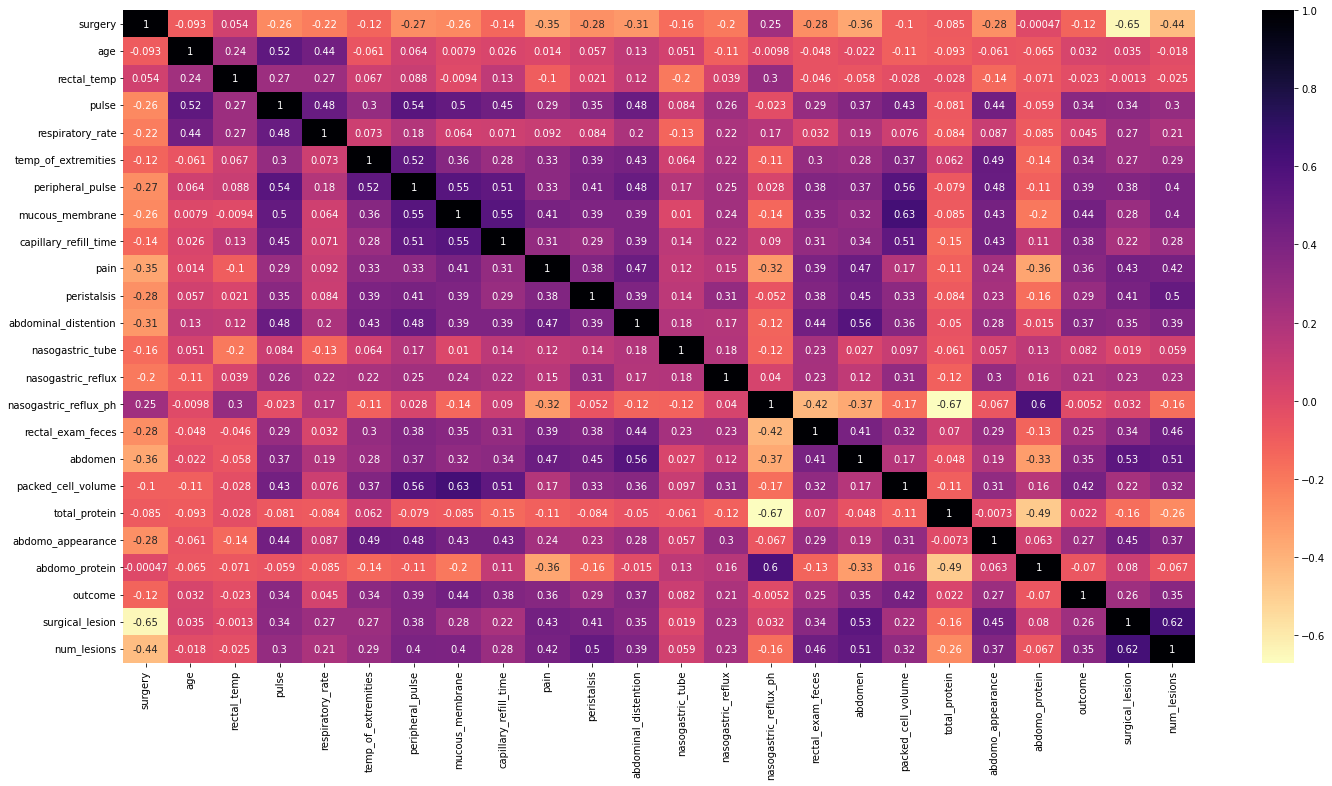

In [11]:
plt.figure(figsize=(24,12))
sns.heatmap(dfTrain.corr(),cmap='magma_r',annot=True)

<AxesSubplot:xlabel='peripheral_pulse', ylabel='outcome'>

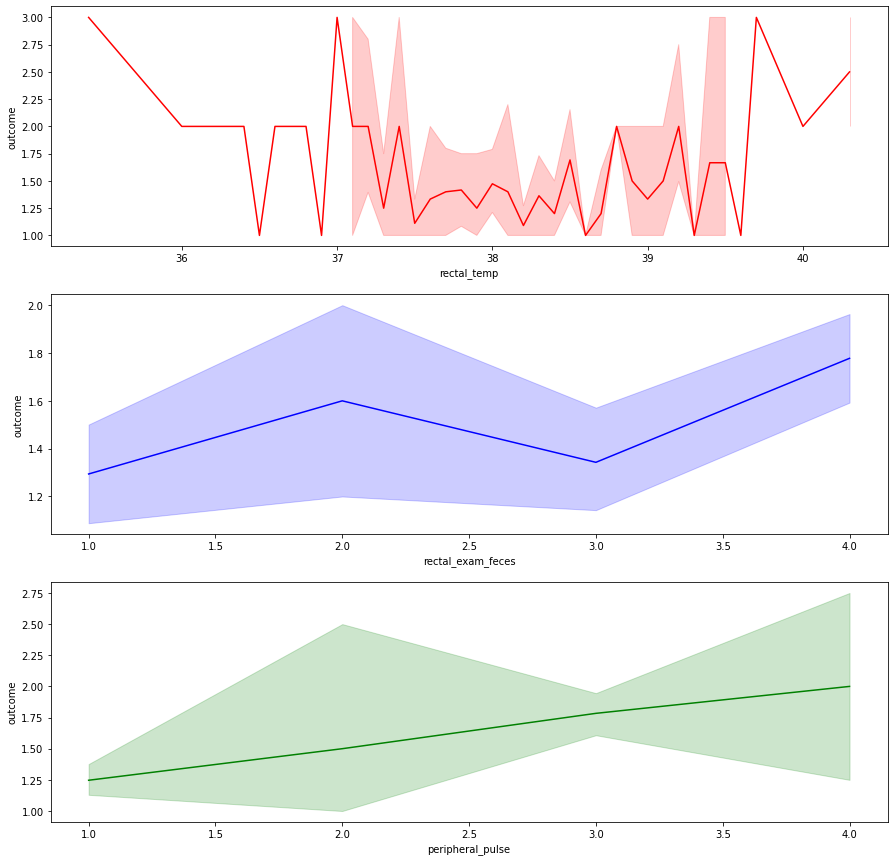

In [12]:
fig,ax = plt.subplots(3,1,figsize=(15,15))
sns.lineplot(x=dfTrain['rectal_temp'],y=dfTrain.outcome,ax=ax[0],color='r') #We visualize 3 features with different levels of correlation with outcome
sns.lineplot(x=dfTrain['rectal_exam_feces'],y=dfTrain.outcome,ax=ax[1],color='b')
sns.lineplot(x=dfTrain['peripheral_pulse'],y=dfTrain.outcome,ax=ax[2],color='g')

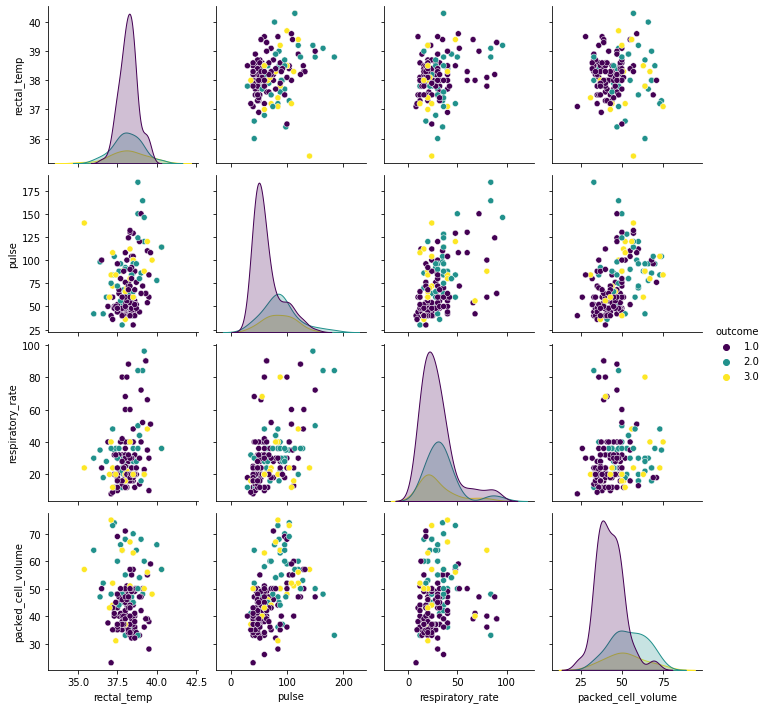

In [13]:
chosen_cols = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'outcome']
sns.pairplot(dfTrain[chosen_cols], hue='outcome', palette = 'viridis'); #We can see a clear correlation for example with high packed cell volume meaning no survival (the same with pulse not with resprate)

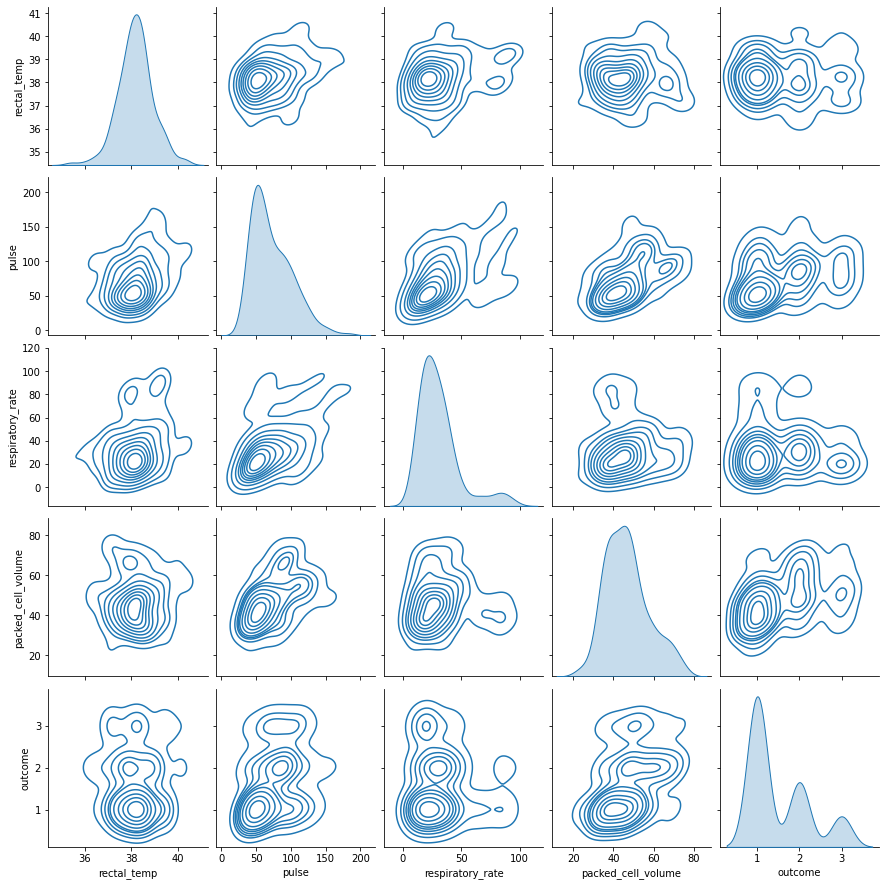

In [14]:
sns.pairplot(dfTrain[chosen_cols], kind="kde"); #This graph helps us show where most values are concentrated in some numerical features

<AxesSubplot:xlabel='pain', ylabel='count'>

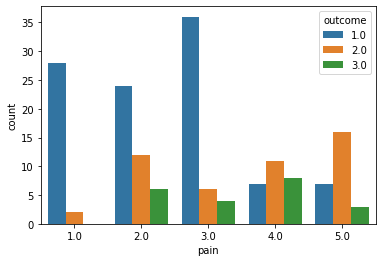

In [15]:
sns.countplot(data=dfTrain, x='pain', hue = 'outcome') #We can see how the bigger the pain, the less the chance of survival

<AxesSubplot:xlabel='mucous_membrane', ylabel='count'>

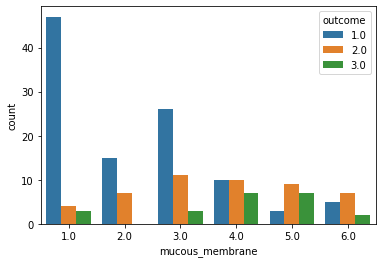

In [16]:
sns.countplot(data=dfTrain, x='mucous_membrane', hue = 'outcome') #We can see how the worse the circulation-> less the chance of survival

<AxesSubplot:xlabel='capillary_refill_time', ylabel='count'>

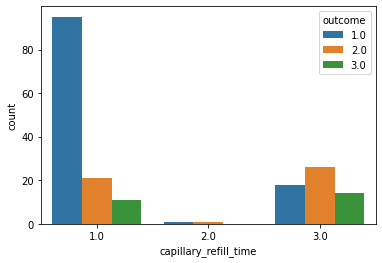

In [17]:
sns.countplot(data=dfTrain, x='capillary_refill_time', hue = 'outcome') #We can see how the worse the circulation-> less the chance of survival

<AxesSubplot:xlabel='peristalsis', ylabel='count'>

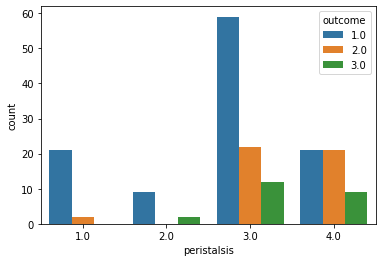

In [18]:
sns.countplot(data=dfTrain, x='peristalsis', hue = 'outcome') #the lesser the activity on the horses gut the lesser the chance of survival

<AxesSubplot:xlabel='abdominal_distention', ylabel='count'>

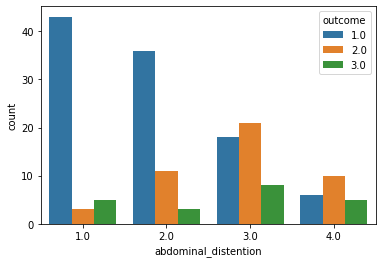

In [19]:
sns.countplot(data=dfTrain, x='abdominal_distention', hue = 'outcome') #the more distended the abdomen the lesser the chance of survival (it means more pain like the documentation says)

<AxesSubplot:xlabel='age', ylabel='count'>

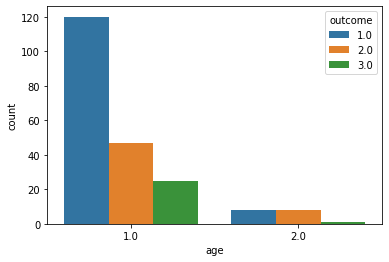

In [20]:
sns.countplot(data=dfTrain, x='age', hue = 'outcome') #surprisingly, the age of the horse doesn't have a big impact on the outcome of the surgery
#however younger horses tend to survive less

# **FILLING MISSING VALUES**

In [21]:
dfTrain.dtypes

surgery                  float64
age                      float64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities      float64
peripheral_pulse         float64
mucous_membrane          float64
capillary_refill_time    float64
pain                     float64
peristalsis              float64
abdominal_distention     float64
nasogastric_tube         float64
nasogastric_reflux       float64
nasogastric_reflux_ph    float64
rectal_exam_feces        float64
abdomen                  float64
packed_cell_volume       float64
total_protein            float64
abdomo_appearance        float64
abdomo_protein           float64
outcome                  float64
surgical_lesion          float64
num_lesions                int64
dtype: object

In [22]:
dfTrain.isna().sum() #There are no columns that have null values in the test dataframe but not in the train dataframe

surgery                    0
age                        0
rectal_temp               41
pulse                     16
respiratory_rate          37
temp_of_extremities       42
peripheral_pulse          50
mucous_membrane           33
capillary_refill_time     22
pain                      39
peristalsis               31
abdominal_distention      40
nasogastric_tube          73
nasogastric_reflux        77
nasogastric_reflux_ph    171
rectal_exam_feces         76
abdomen                   80
packed_cell_volume        21
total_protein             21
abdomo_appearance        117
abdomo_protein           144
outcome                    0
surgical_lesion            0
num_lesions                0
dtype: int64

In [23]:
#We start finding which columns to eliminate
for col in dfTrain.columns:
  if dfTrain[col].isna().sum() > 120: #More than 50% missing values
    print('Column ' + col + ' --> NULL VALUES: ' + str(dfTrain[col].isna().sum()) + ' --> Correlation with target of ' + str(dfTrain.corr()['outcome'][col]))

Column nasogastric_reflux_ph --> NULL VALUES: 171 --> Correlation with target of -0.005194866451076158
Column abdomo_protein --> NULL VALUES: 144 --> Correlation with target of -0.07010227029698288


In [24]:
#We drop columns nasogastric_reflux_ph and abdomo_protein as they don't hold a significant correlation with the target and they have > 50% of null values in the train dataset
#Filling their null values would cause more harm than good
dfTrain = dfTrain.drop(columns = ['abdomo_protein', 'nasogastric_reflux_ph'], axis = 1)
dfTest = dfTest.drop(columns = ['abdomo_protein', 'nasogastric_reflux_ph'], axis = 1)

In [25]:
dfTrain.shape

(209, 22)

<AxesSubplot:>

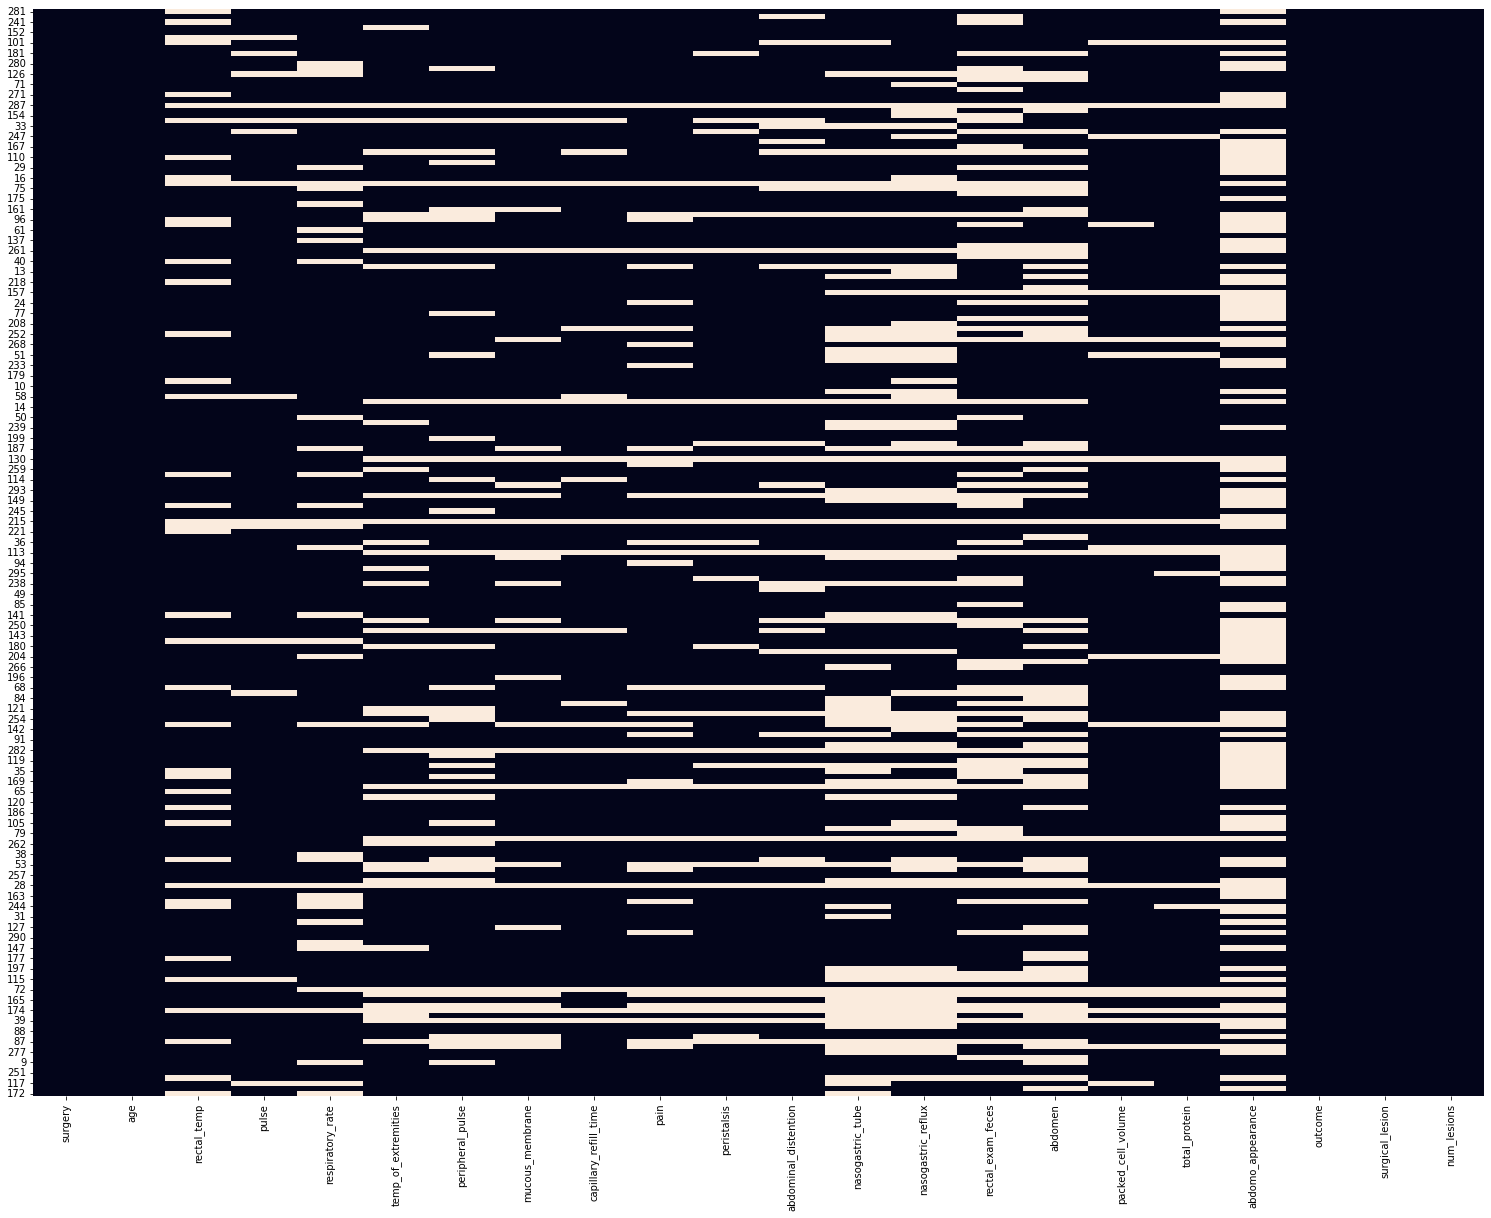

In [26]:
plt.figure(figsize=(26,20))
sns.heatmap(dfTrain.isnull(), cbar=False)

In [27]:
#We will use different approaches to fill the missing values on categorical and numerical variables

In [28]:
#We create vectors for the categorical and the numerical features that have missing values
cat_features = ['surgery' , 'age', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance']
       
num_features = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']

LETS FIRST FILL THE MISSING VALUES OF THE CATEGORICAL FEATURES

In [29]:
dfTrain.dtypes

surgery                  float64
age                      float64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities      float64
peripheral_pulse         float64
mucous_membrane          float64
capillary_refill_time    float64
pain                     float64
peristalsis              float64
abdominal_distention     float64
nasogastric_tube         float64
nasogastric_reflux       float64
rectal_exam_feces        float64
abdomen                  float64
packed_cell_volume       float64
total_protein            float64
abdomo_appearance        float64
outcome                  float64
surgical_lesion          float64
num_lesions                int64
dtype: object

In [30]:
#We will use a KNNImputer to imput the categorical features
dfTestOrig = dfTest
KNNimpTR = KNNImputer(n_neighbors=1)
dfTrain = pd.DataFrame(KNNimpTR.fit_transform(dfTrain),columns = dfTrain.columns)
KNNimpTS = KNNImputer(n_neighbors=1)
dfTest = pd.DataFrame(KNNimpTS.fit_transform(dfTest),columns = dfTest.columns)

<AxesSubplot:>

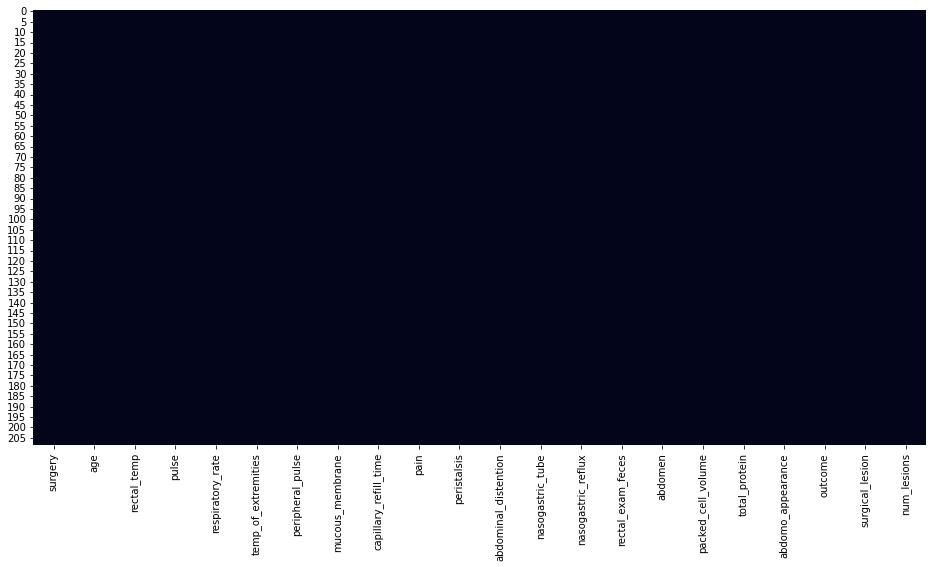

In [31]:
plt.figure(figsize=(16,8))
sns.heatmap(dfTrain.isnull(), cbar=False) #The last row has null on all the categorical variables so there's no way to fill it with the KNN imputer

In [32]:
dfTrain.isna().sum() #No missing values remain!

surgery                  0
age                      0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
outcome                  0
surgical_lesion          0
num_lesions              0
dtype: int64

# OUTLIER DETECTION

<AxesSubplot:>

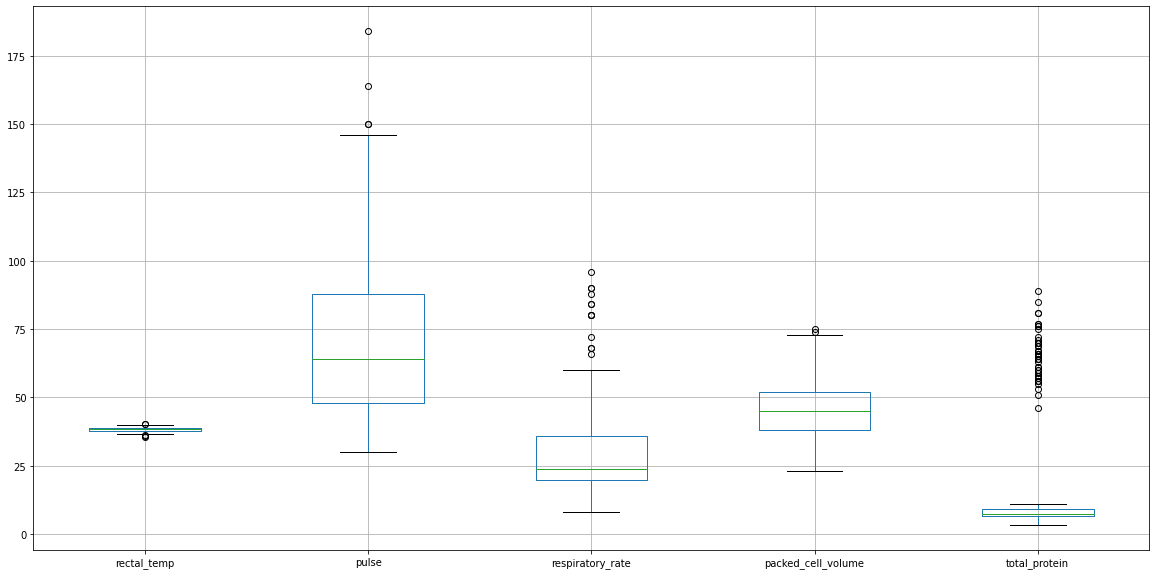

In [33]:
dfTrain[num_features].boxplot(figsize = (20,10))

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='pulse'>

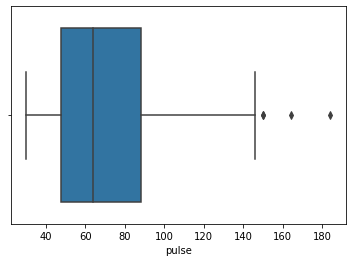

In [34]:
sns.boxplot(dfTrain['pulse'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='respiratory_rate'>

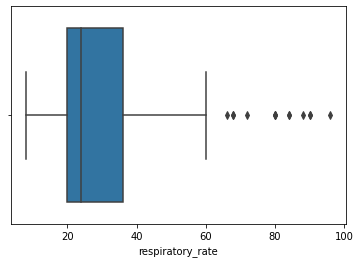

In [35]:
sns.boxplot(dfTrain['respiratory_rate'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='packed_cell_volume'>

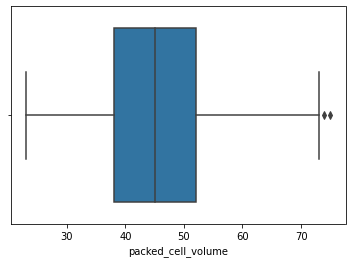

In [36]:
sns.boxplot(dfTrain['packed_cell_volume']) #We can ignore these small outliers

We will delete the outliers

In [37]:
Q1 = dfTrain['respiratory_rate'].quantile(0.15)
Q3 = dfTrain['respiratory_rate'].quantile(0.85)
IQR = Q3 - Q1
big_outliers = dfTrain['respiratory_rate'] > (Q3 + 1.5 * IQR)
dfTrain[big_outliers] 

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,outcome,surgical_lesion,num_lesions
53,1.0,2.0,39.1,164.0,84.0,4.0,1.0,6.0,3.0,2.0,...,1.0,2.0,3.0,5.0,48.0,7.2,3.0,2.0,1.0,1.0
64,1.0,1.0,39.3,64.0,90.0,2.0,3.0,1.0,1.0,5.0,...,1.0,2.0,1.0,5.0,39.0,6.7,1.0,1.0,1.0,1.0
87,1.0,1.0,37.8,88.0,80.0,3.0,3.0,5.0,3.0,5.0,...,2.0,3.0,4.0,5.0,64.0,89.0,3.0,3.0,1.0,1.0
132,1.0,1.0,37.8,60.0,80.0,1.0,3.0,2.0,3.0,2.0,...,2.0,2.0,4.0,5.0,40.0,4.5,2.0,1.0,1.0,1.0
136,1.0,2.0,38.8,184.0,84.0,1.0,1.0,1.0,1.0,4.0,...,1.0,3.0,2.0,5.0,33.0,3.3,2.0,2.0,1.0,1.0
141,1.0,2.0,38.1,100.0,80.0,3.0,1.0,2.0,1.0,3.0,...,1.0,0.0,1.0,5.0,36.0,5.7,2.0,1.0,1.0,1.0
177,1.0,1.0,39.3,64.0,90.0,2.0,3.0,1.0,1.0,5.0,...,1.0,2.0,1.0,5.0,39.0,6.7,1.0,1.0,1.0,1.0
185,1.0,2.0,38.2,124.0,88.0,1.0,3.0,2.0,1.0,2.0,...,3.0,3.0,4.0,5.0,47.0,8.0,1.0,1.0,1.0,1.0
194,1.0,2.0,39.2,146.0,96.0,3.0,3.0,3.0,2.0,5.0,...,3.0,2.0,4.0,5.0,46.0,5.9,2.0,2.0,1.0,1.0


In [38]:
dfTrain[big_outliers].index

Int64Index([53, 64, 87, 132, 136, 141, 177, 185, 194], dtype='int64')

In [39]:
dfTrain.drop(labels=dfTrain[big_outliers].index, axis=0, inplace = True)

In [40]:
Q1 = dfTrain['pulse'].quantile(0.25)
Q3 = dfTrain['pulse'].quantile(0.75)
IQR = Q3 - Q1
big_outliers_2 = dfTrain['pulse'] > (Q3 + 1.5 * IQR)
dfTrain[big_outliers_2] #We will not drop these rows with outliers for now

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,outcome,surgical_lesion,num_lesions
45,1.0,2.0,38.8,150.0,50.0,1.0,3.0,6.0,3.0,5.0,...,1.0,0.0,4.0,5.0,50.0,6.2,1.0,2.0,1.0,1.0
75,2.0,2.0,39.0,150.0,72.0,3.0,3.0,4.0,3.0,3.0,...,3.0,3.0,4.0,5.0,47.0,8.5,1.0,1.0,1.0,1.0


In [41]:
dfTrain.drop(labels=dfTrain[big_outliers_2].index, axis=0, inplace = True)

# **NORMALIZATION OF THE VARIABLES**

In [42]:
#We also standardize the categorical variables
target = dfTrain['outcome']
dfTrain = dfTrain.drop(columns = ['outcome'], axis = 1) #We extract the target to avoid standardizing it
features = dfTrain.columns
scaler = StandardScaler()
scaledTrain = scaler.fit_transform(dfTrain)
scaledTest = scaler.transform(dfTest) #we transform the test set with the model trained on the train set
dfTrain = pd.DataFrame(data=scaledTrain, columns=features)
dfTest = pd.DataFrame(data=scaledTest, columns=features) #We rebuild to a dataframe format"""

array([[<AxesSubplot:title={'center':'surgery'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'rectal_temp'}>,
        <AxesSubplot:title={'center':'pulse'}>,
        <AxesSubplot:title={'center':'respiratory_rate'}>],
       [<AxesSubplot:title={'center':'temp_of_extremities'}>,
        <AxesSubplot:title={'center':'peripheral_pulse'}>,
        <AxesSubplot:title={'center':'mucous_membrane'}>,
        <AxesSubplot:title={'center':'capillary_refill_time'}>,
        <AxesSubplot:title={'center':'pain'}>],
       [<AxesSubplot:title={'center':'peristalsis'}>,
        <AxesSubplot:title={'center':'abdominal_distention'}>,
        <AxesSubplot:title={'center':'nasogastric_tube'}>,
        <AxesSubplot:title={'center':'nasogastric_reflux'}>,
        <AxesSubplot:title={'center':'rectal_exam_feces'}>],
       [<AxesSubplot:title={'center':'abdomen'}>,
        <AxesSubplot:title={'center':'packed_cell_volume'}>,
        <AxesSubplot:title={'center':'tota

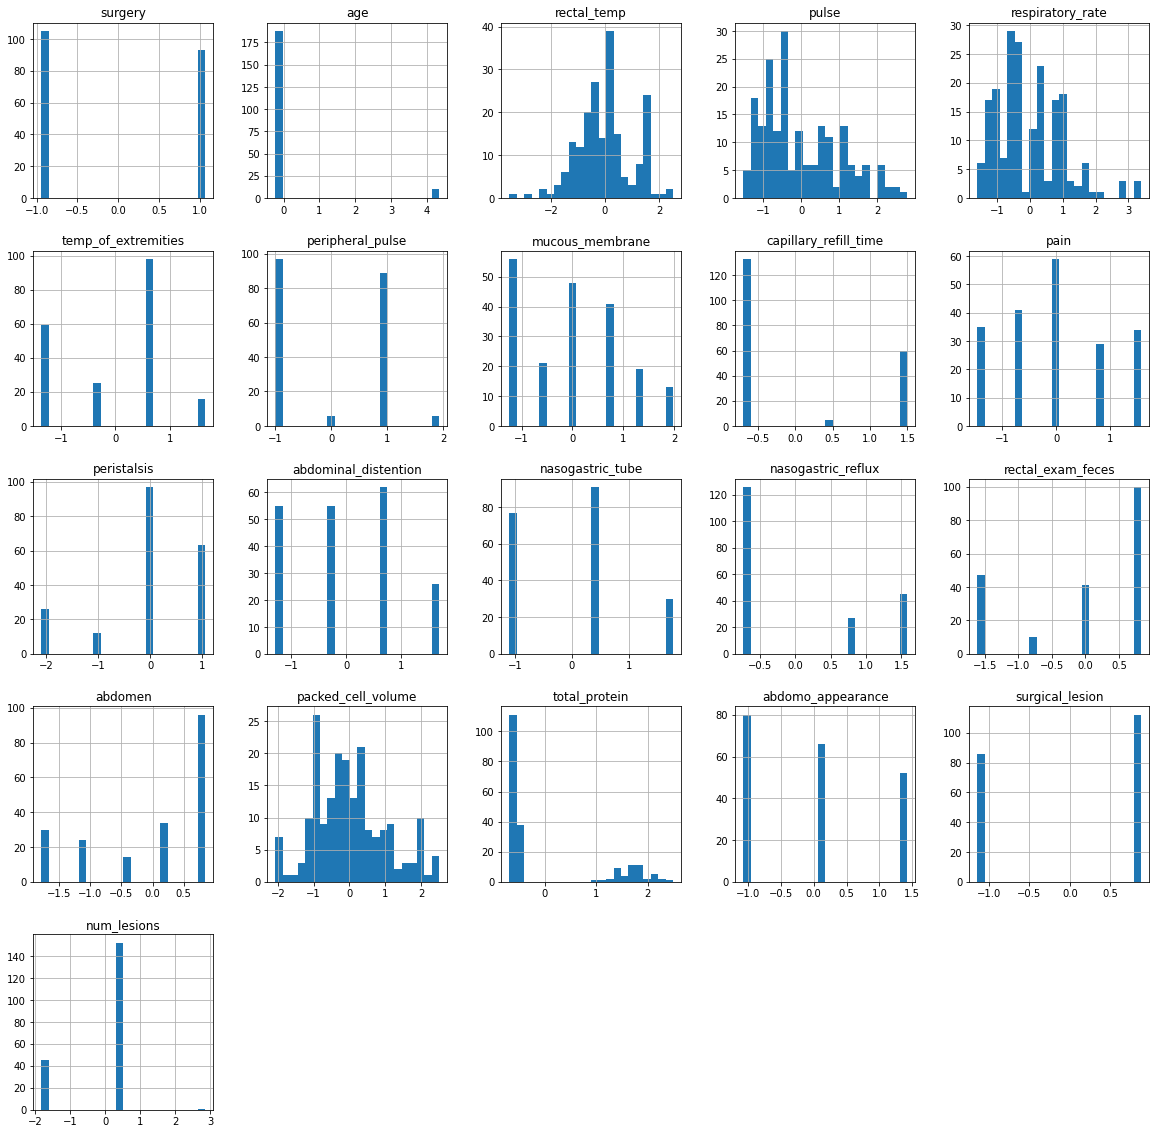

In [43]:
dfTrain.hist(bins=22, figsize=(20, 20))

# **TRANSFORMATION OF VARIABLES**

In [44]:
print(dfTrain['pulse'].skew()) #We will fix variables with a skewness > 0.5
print(dfTrain['respiratory_rate'].skew())
print(dfTrain['total_protein'].skew())
print(dfTrain['packed_cell_volume'].skew())
print(dfTrain['rectal_temp'].skew())

0.6784095668305062
0.8954276780497089
1.263113842283927
0.39624755843923365
-0.06510355845160573


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


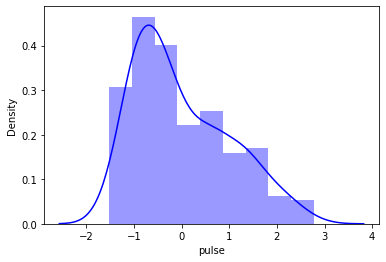

In [45]:
sns.distplot(dfTrain["pulse"] , color = "b", hist_kws={"alpha": 0.4});

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


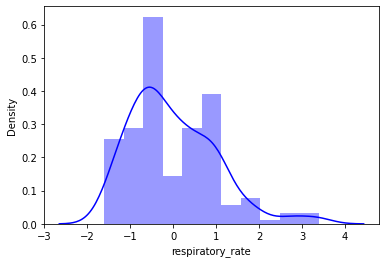

In [46]:
sns.distplot(dfTrain["respiratory_rate"] , color = "b", hist_kws={"alpha": 0.4});

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


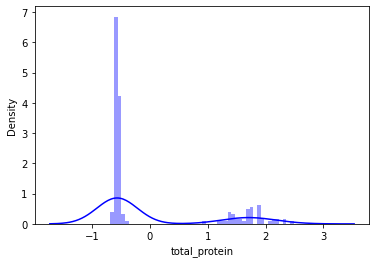

In [47]:
sns.distplot(dfTrain["total_protein"] , color = "b", hist_kws={"alpha": 0.4});

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


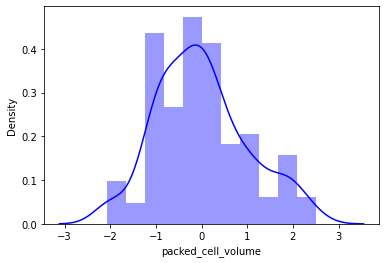

In [48]:
sns.distplot(dfTrain["packed_cell_volume"] , color = "b", hist_kws={"alpha": 0.4}); #This distribution looks less skewed (more gaussian)

In [49]:
cols_not_normal = ['pulse', 'respiratory_rate', 'total_protein']

PT = PowerTransformer()

PTx_train = PT.fit_transform(dfTrain)
PTx_test = PT.transform(dfTest)

dfTrain2 = pd.DataFrame(data=PTx_train, columns=features)
dfTest2 = pd.DataFrame(data=PTx_test, columns=features)

dfTrain[cols_not_normal] = dfTrain2[cols_not_normal]
dfTest[cols_not_normal] = dfTest2[cols_not_normal]

dfTrain.insert(21,"outcome",target.values) #we add the target feature again

array([[<AxesSubplot:title={'center':'surgery'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'rectal_temp'}>,
        <AxesSubplot:title={'center':'pulse'}>,
        <AxesSubplot:title={'center':'respiratory_rate'}>],
       [<AxesSubplot:title={'center':'temp_of_extremities'}>,
        <AxesSubplot:title={'center':'peripheral_pulse'}>,
        <AxesSubplot:title={'center':'mucous_membrane'}>,
        <AxesSubplot:title={'center':'capillary_refill_time'}>,
        <AxesSubplot:title={'center':'pain'}>],
       [<AxesSubplot:title={'center':'peristalsis'}>,
        <AxesSubplot:title={'center':'abdominal_distention'}>,
        <AxesSubplot:title={'center':'nasogastric_tube'}>,
        <AxesSubplot:title={'center':'nasogastric_reflux'}>,
        <AxesSubplot:title={'center':'rectal_exam_feces'}>],
       [<AxesSubplot:title={'center':'abdomen'}>,
        <AxesSubplot:title={'center':'packed_cell_volume'}>,
        <AxesSubplot:title={'center':'tota

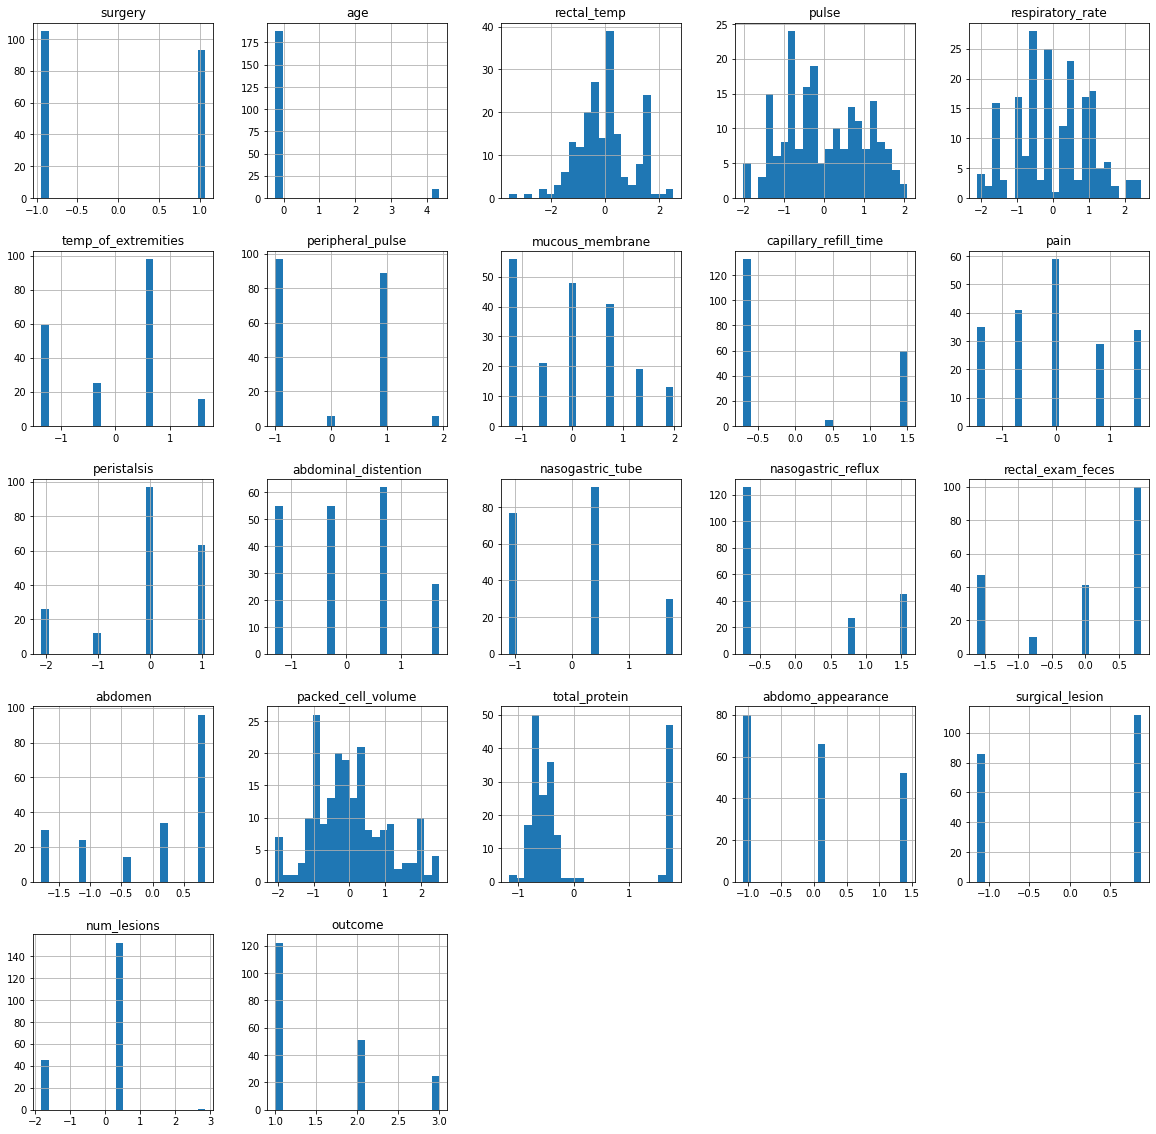

In [50]:
dfTrain.hist(bins=22, figsize=(20, 20))

In [51]:
print(dfTrain['pulse'].skew())
print(dfTrain['respiratory_rate'].skew())
print(dfTrain['total_protein'].skew()) #Skewness fixed!

0.09392981690050352
0.06573999409819924
1.099608870661547


In [52]:
dfTrain.corr()['outcome']['total_protein'] #No correlation!

-0.07519364477451548

Since total_protein doesn't improve its skewness (its distribution is totally abnormal) and its correlation with the target is inexistent, we decide to eliminate it.

In [53]:
dfTrain.drop(columns=['total_protein'], axis = 1, inplace = True)
dfTest.drop(columns=['total_protein'], axis = 1, inplace = True)

# **MODEL SELECTION**

In [54]:
y_train = dfTrain['outcome']
x_train = dfTrain.drop(columns = ['outcome'], axis = 1)
x_test = dfTest

**Logistic Regression**

In [55]:
lr = LogisticRegression(random_state=0)
param_grid={"C":np.logspace(-3,3,10)}
grid = GridSearchCV(lr, param_grid, cv=5, verbose=0)
grid_search=grid.fit(x_train, y_train)
print('The best value found for the hyperparameter C is ' + str(grid_search.best_params_['C']))
print('The best result on the training set using 5-Fold CV was ' + str(grid_search.best_score_))
y_pred = grid_search.predict(x_test)
print('The best result predicting the test set was ' + str(accuracy_score(y_test, y_pred)))
confusion_matrix(y_test, y_pred)

The best value found for the hyperparameter C is 0.004641588833612777
The best result on the training set using 5-Fold CV was 0.6767948717948717
The best result predicting the test set was 0.5444444444444444


array([[45,  5,  0],
       [18,  4,  0],
       [10,  8,  0]])

## Conclusion

1. Performed Exploratory Data Analysis on horse-colic dataset.
2. Preprocessed the data so that a Logistic Regression model could be trained on it.
2. Applying logistic regression model on the dataset, I found that:

* The best value found for the hyperparameter C is 0.004641588833612777
* The best result on the training set was 0.6767948717948717
* The best result predicting the test set was 0.5444444444444444

# **THE END!**